# LAMAP Classic — A Transparent, Reproducible Walkthrough


This notebook reconstructs **LAMAP (Locally Adaptive Model of Archaeological Potential)** step‑by‑step with math then code.


## 1. Overview of the model


For a target cell $x$ and variables $X_v(x)$:

- ECDF per site & variable $F_{j,v}$ from catchment samples.  
- Interval mass: $p_{j,v}(x)=F_{j,v}(X_v(x)+\epsilon_v)-F_{j,v}(X_v(x)-\epsilon_v)$.  
- Site mass: $p_j(x)=\prod_v p_{j,v}(x)$.  
- Distance weight: $w_j(x)=\exp(-\lambda d(x,s_j))$.  
- Combine sites: $U(x)=1-\prod_j(1-w_j p_j)$.


In [1]:

# Imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Any, Tuple
np.set_printoptions(precision=4, suppress=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable


### 2. ECDF interval mass and independence union

In [2]:
# ---------- ECDF interval mass ----------
def ecdf_interval_mass(sorted_sample: np.ndarray, a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Empirical mass P(a <= Z <= b) using binary searches over a sorted sample.
    a, b are broadcastable to the number of target cells (C).
    """
    left = np.searchsorted(sorted_sample, a, side='left')
    right = np.searchsorted(sorted_sample, b, side='right')
    n = max(sorted_sample.size, 1)
    mass = (right - left) / n
    # mass ∈ [0,1] naturally; clip guards rare numerical quirks
    return np.clip(mass, 0.0, 1.0)

# ---------- Stable union (independent sites) ----------
def union_independent_from_q(q: np.ndarray) -> np.ndarray:
    """
    q shape [S, C]; returns U shape [C].
    U = 1 - Π_j (1 - q_j). Compute via log(1-U) = Σ_j log(1 - q_j).
    """
    q = np.clip(q, 0.0, 1.0 - 1e-12)  # avoid log(0) in log1p(-q)
    log1m_q = np.log1p(-q)            # log(1 - q)
    log1m_U = np.sum(log1m_q, axis=0)
    U = 1.0 - np.exp(log1m_U)
    return np.clip(U, 0.0, 1.0)

# ---------- Distance weighting ----------
def w_exponential(dist: np.ndarray, rate: float, scale: float) -> np.ndarray:
    """
    Exponential weighting used in your R code: exp( -(dist/scale) * rate ).
    dist shape [S, C] or [C] or [S], returns same shape.
    """
    return np.exp(-(dist/scale) * rate)

def w_uniform(dist: np.ndarray, cutoff: float) -> np.ndarray:
    return (dist <= cutoff).astype(np.float64)

# ---------- K-nearest sites per cell ----------
def topk_mask_from_dist(dist_SC: np.ndarray, k: int) -> np.ndarray:
    """
    dist_SC shape [S, C]. Returns boolean mask [S, C] where True means
    "site is among the k nearest for that cell".
    """
    S, C = dist_SC.shape
    k_eff = min(k, S)
    idx = np.argpartition(dist_SC, kth=k_eff-1, axis=0)[:k_eff, :]  # (k_eff, C)
    mask = np.zeros((S, C), dtype=bool)
    # robust column-wise fill (no tricky broadcasting)
    for c in range(C):
        mask[idx[:, c], c] = True
    return mask

# ---------- Small utility ----------
@dataclass
class Site:
    id: Any
    x: float
    y: float

def circular_mask(cy: float, cx: float, radius: float, shape: Tuple[int,int]) -> np.ndarray:
    yy, xx = np.ogrid[:shape[0], :shape[1]]
    return (yy - cy)**2 + (xx - cx)**2 <= radius**2


In [3]:
# Toy sorted sample (catchment values for one variable)
sample = np.array([0.1, 0.2, 0.2, 0.3, 0.7, 0.8])
n = sample.size

# Define test intervals
tests = {
    "1. inside":       (0.15, 0.35),   # covers 0.2,0.2,0.3
    "2. below":        (-1.0, -0.5),   # entirely below min(sample)
    "3. above":        (1.0, 2.0),     # entirely above max(sample)
    "4. partial low":  (-1.0, 0.25),   # partly below, up to inside
    "5. partial high": (0.25, 2.0),    # partly inside, partly above
    "6. full cover":   (-1.0, 2.0),    # covers whole support
}

# Evaluate and print
for name, (a, b) in tests.items():
    m = ecdf_interval_mass(sample, a, b)
    print(f"{name:15s} interval=({a},{b}) mass={m:.3f}")

1. inside       interval=(0.15,0.35) mass=0.500
2. below        interval=(-1.0,-0.5) mass=0.000
3. above        interval=(1.0,2.0) mass=0.000
4. partial low  interval=(-1.0,0.25) mass=0.500
5. partial high interval=(0.25,2.0) mass=0.500
6. full cover   interval=(-1.0,2.0) mass=1.000


In [4]:
# --- Simulated raster ---
H, W = 80, 100  # small for demo
ygrid, xgrid = np.meshgrid(np.arange(H) + 0.5, np.arange(W) + 0.5, indexing='ij')
C = H * W

# Variables (smooth but nontrivial)
elev  = 120 + 0.35*xgrid + 0.15*ygrid + 8*np.sin(xgrid/15.0) + 5*np.cos(ygrid/21.0)
gy, gx = np.gradient(elev)
slope = np.hypot(gx, gy)

river_y = H/2 + 10*np.sin(np.linspace(0, 3*np.pi, W))
river = np.zeros((H, W), dtype=bool)
for j in range(W):
    rj = int(np.clip(river_y[j], 0, H-1))
    river[max(0, rj-1):min(H, rj+2), j] = True
# Cheap EDT replacement (small grid): brute-force min distance to river pixels
r_idx = np.argwhere(river)
if r_idx.size:
    yy = np.repeat(np.arange(H), W)
    xx = np.tile(np.arange(W), H)
    pts = np.column_stack([yy, xx])
    d2 = np.sum((pts[:, None, :] - r_idx[None, :, :])**2, axis=2)
    d2_min = d2.min(axis=1)
    d2_min = d2_min.reshape(H, W)
    d2w = np.sqrt(d2_min)
else:
    d2w = np.full((H, W), 99.0)

# Stack variables
vars_dict = {'elev': elev, 'slope': slope, 'd2w': d2w}
Vnames = list(vars_dict.keys())
V = len(Vnames)

# Sites (a few)
sites = [
    Site('A', 20.0, 25.0),
    Site('B', 70.0, 35.0),
    Site('C', 50.0, 60.0),
    Site('D', 30.0, 10.0),
    Site('E', 85.0, 65.0),
]
S = len(sites)

# Build site catchment samples (sorted) per (site, var)
catchment_radius = 15
site_samples = {s.id: {} for s in sites}
for s in sites:
    mask = circular_mask(s.y, s.x, catchment_radius, (H, W))
    for v in Vnames:
        arr = vars_dict[v][mask].ravel()
        arr = arr[np.isfinite(arr)]
        site_samples[s.id][v] = np.sort(arr)

# Flatten raster variables + build per-variable bounds (x ± ε_v)
eps = {'elev': 10.0, 'slope': 0.1, 'd2w': 10.0}
Xv = {v: vars_dict[v].ravel().astype(np.float64) for v in Vnames}
A = {v: Xv[v] - eps[v] for v in Vnames}
B = {v: Xv[v] + eps[v] for v in Vnames}

# Precompute per-cell coordinates (for distances)
Xc = xgrid.ravel()
Yc = ygrid.ravel()


In [5]:
# Distances [S, C]
D = np.empty((S, C), dtype=np.float64)
for j, s in enumerate(sites):
    D[j, :] = np.hypot(Xc - s.x, Yc - s.y)

# Keep only K nearest sites per cell (others ignored)
K = 5  # e.g., 3 nearest sites for demo
mask_topk = topk_mask_from_dist(D, K)  # [S, C] boolean

# Distance weights (exponential) and take logs
# R-like: w = exp( -(d/scale)*rate ). Pick rate, scale that give reasonable spread.
rate, scale = 0.25, max(H, W)  # simple demo choice
Ww = w_exponential(D, rate=rate, scale=scale)  # <-- renamed
logW = np.log(Ww, where=(Ww > 0), out=np.full_like(Ww, -np.inf))


In [6]:
# Build logP[v, j, c] = log( mass_{v,j}(c) ) using searchsorted
tiny = 1e-300  # for log(0) guard

logP = np.full((V, S, C), -np.inf, dtype=np.float64)  # init to -inf
for vi, v in enumerate(Vnames):
    a = A[v]  # [C]
    b = B[v]  # [C]
    for j, s in enumerate(sites):
        ss = site_samples[s.id][v]  # sorted sample for (site, var)
        if ss.size == 0:
            continue
        mass = ecdf_interval_mass(ss, a, b)            # [C] in [0,1]
        # log mass with guard
        logP[vi, j, :] = np.log(np.maximum(mass, tiny))


In [7]:
def log1mexp_vector(x: np.ndarray) -> np.ndarray:
    """
    Stable elementwise log(1 - exp(x)) for x <= 0.
    Handles x = -inf (returns 0), x = 0 (returns -inf).
    """
    x = np.asarray(x, dtype=np.float64)
    x = np.minimum(x, 0.0)  # enforce x <= 0 for safety
    cutoff = -np.log(2.0)   # ~ -0.6931
    with np.errstate(over='ignore', under='ignore', divide='ignore', invalid='ignore'):
        return np.where(
            x <= cutoff,
            np.log1p(-np.exp(x)),     # safe when exp(x) is small
            np.log(-np.expm1(x))      # safe when exp(x) ~ 1
        )

def union_from_logQ(logQ: np.ndarray) -> np.ndarray:
    """
    Given logQ [S, C] with logQ_jc = log(q_jc) <= 0 or -inf,
    compute U[c] = 1 - prod_j (1 - q_jc) in a numerically stable way.
    """
    X = np.asarray(logQ, dtype=np.float64)
    # Treat any NaN as 'no contribution' (log 0):
    X = np.where(np.isfinite(X), X, -np.inf)
    X = np.minimum(X, 0.0)  # enforce logQ <= 0
    log1mQ = log1mexp_vector(X)                       # [S, C]
    log1mU = np.sum(log1mQ, axis=0, dtype=np.float64) # [C]
    with np.errstate(over='ignore', under='ignore'):
        U = 1.0 - np.exp(log1mU)                      # [C]
    return np.clip(U, 0.0, 1.0)


In [8]:
# --- combine across variables (sum of logs) ---
logPsite = np.sum(np.asarray(logP, dtype=np.float64), axis=0, dtype=np.float64)  # [S, C]

# --- K-nearest masking (set non-topK to -inf) ---
logPsite_masked = logPsite.copy()
logPsite_masked[~mask_topk] = -np.inf

# --- add log distance weights ---
logW64 = np.asarray(logW, dtype=np.float64)
logQ = logW64 + logPsite_masked  # [S, C] float64

# --- compute union entirely in log-space ---
U_flat = union_from_logQ(logQ)   # [C]
U = U_flat.reshape(H, W)

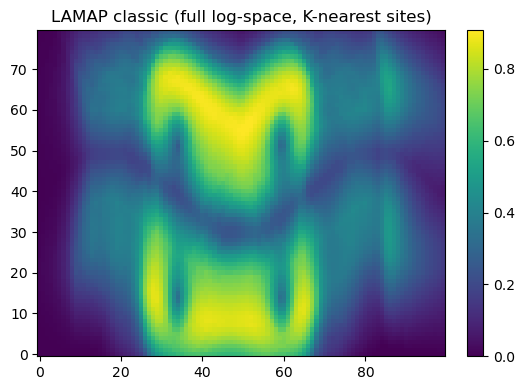

U stats: 0.0 0.9071167341136113 0.3793872637681348


In [9]:
# --- gentle warning if many cells had zero support across top-K sites ---
all_zero_support = np.all(~np.isfinite(logQ), axis=0)  # True if every site's logQ was -inf
frac_zero = float(all_zero_support.mean())
if frac_zero > 0.05:
    print(f"Warning: {frac_zero:.1%} of cells had zero support across the top-K sites. "
          "Consider increasing eps, enlarging catchments, or using more sites (K).")

# --- plot ---
plt.figure(figsize=(6,4))
plt.imshow(U, origin='lower')
plt.title("LAMAP classic (full log-space, K-nearest sites)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

print("U stats:", float(U.min()), float(U.max()), float(U.mean()))


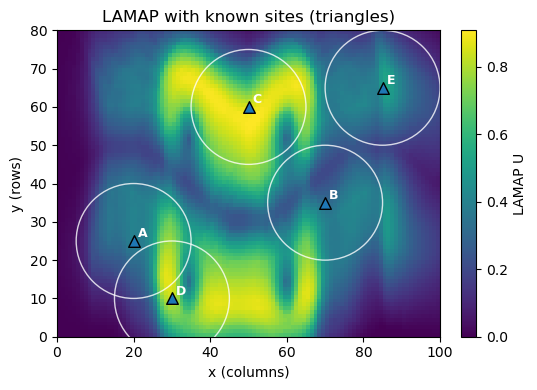

In [10]:
# --- Overlay known sites (and optional catchments) on the LAMAP map ---

fig, ax = plt.subplots(figsize=(6, 4))

# Use extent so axes show raster coords (x: 0..W, y: 0..H)
im = ax.imshow(U, origin="lower", extent=(0, W, 0, H))
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label("LAMAP U")

# Scatter the site centers
sx = [s.x for s in sites]
sy = [s.y for s in sites]
ax.scatter(sx, sy, s=70, marker="^", edgecolors="k", linewidths=1.0)

# Label each site
for s in sites:
    ax.text(s.x + 1.0, s.y + 1.0, str(s.id),
            fontsize=9, color="white", weight="bold",
            path_effects=[])

# OPTIONAL: draw catchment circles (use your catchment_radius from earlier)
draw_circles = True
if draw_circles:
    for s in sites:
        circ = plt.Circle((s.x, s.y),
                          radius=catchment_radius,
                          fill=False, linewidth=1.0, alpha=0.8,
                          edgecolor="white")
        ax.add_patch(circ)

ax.set_xlim(0, W)
ax.set_ylim(0, H)
ax.set_xlabel("x (columns)")
ax.set_ylabel("y (rows)")
ax.set_title("LAMAP with known sites (triangles)")

plt.tight_layout()
plt.show()


In [11]:
# --- helpers ---
# - Site dataclass
# - circular_mask(...)
# - ecdf_interval_mass(...)
# - topk_mask_from_dist(...)
# - w_exponential(...)

def log1mexp_vector(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=np.float64)
    x = np.minimum(x, 0.0)  # enforce x <= 0
    cutoff = -np.log(2.0)
    with np.errstate(over='ignore', under='ignore', divide='ignore', invalid='ignore'):
        return np.where(
            x <= cutoff, np.log1p(-np.exp(x)), np.log(-np.expm1(x))
        )

def union_from_logQ(logQ: np.ndarray) -> np.ndarray:
    X = np.asarray(logQ, dtype=np.float64)
    X = np.where(np.isfinite(X), X, -np.inf)
    X = np.minimum(X, 0.0)
    log1mQ = log1mexp_vector(X)
    log1mU = np.sum(log1mQ, axis=0, dtype=np.float64)
    with np.errstate(over='ignore', under='ignore'):
        U = 1.0 - np.exp(log1mU)
    return np.clip(U, 0.0, 1.0)

def build_site_ecdfs(sites: List[Site],
                     vars_dict: Dict[str, np.ndarray],
                     catchment_radius: float) -> Dict[Any, Dict[str, np.ndarray]]:
    """Per-site, per-variable sorted samples from circular catchments."""
    H, Wcols = next(iter(vars_dict.values())).shape
    samples = {s.id: {} for s in sites}
    for s in sites:
        mask = circular_mask(s.y, s.x, catchment_radius, (H, Wcols))
        for v, arr in vars_dict.items():
            vals = arr[mask].ravel()
            vals = vals[np.isfinite(vals)]
            samples[s.id][v] = np.sort(vals)
    return samples

def lamap_from_sites(sites: List[Site],
                     vars_dict: Dict[str, np.ndarray],
                     eps: Dict[str, float],
                     K: int,
                     rate: float,
                     scale: float,
                     catchment_radius: float) -> Tuple[np.ndarray, Dict[str, Any]]:
    """
    Compute a LAMAP surface U (H×W) for a given site set and parameters.
    Returns (U, debug) where debug holds intermediates if you want to inspect.
    """
    # grid & flatten
    H, Wcols = next(iter(vars_dict.values())).shape
    ygrid, xgrid = np.meshgrid(np.arange(H) + 0.5, np.arange(Wcols) + 0.5, indexing='ij')
    Xc = xgrid.ravel()
    Yc = ygrid.ravel()
    C = H * Wcols
    Vnames = list(vars_dict.keys())
    V = len(Vnames)
    # bounds per variable
    Xv = {v: vars_dict[v].ravel().astype(np.float64) for v in Vnames}
    A = {v: Xv[v] - eps[v] for v in Vnames}
    B = {v: Xv[v] + eps[v] for v in Vnames}

    # ECDF samples per site
    site_samples = build_site_ecdfs(sites, vars_dict, catchment_radius)

    # distances [S, C]
    S = len(sites)
    D = np.empty((S, C), dtype=np.float64)
    for j, s in enumerate(sites):
        D[j, :] = np.hypot(Xc - s.x, Yc - s.y)

    # K-nearest mask
    mask_topk = topk_mask_from_dist(D, min(K, S))

    # distance weights (log)
    Ww = w_exponential(D, rate=rate, scale=scale)  # (0,1]
    logW = np.log(Ww, where=(Ww > 0), out=np.full_like(Ww, -np.inf))

    # logP[v, j, c]
    tiny = 1e-300
    logP = np.full((V, S, C), -np.inf, dtype=np.float64)
    for vi, v in enumerate(Vnames):
        a, b = A[v], B[v]
        for j, s in enumerate(sites):
            ss = site_samples[s.id][v]
            if ss.size == 0:
                continue
            mass = ecdf_interval_mass(ss, a, b)       # [C] in [0,1]
            logP[vi, j, :] = np.log(np.maximum(mass, tiny))

    # sum across variables (independence within site)
    logPsite = np.sum(logP, axis=0, dtype=np.float64)      # [S, C]
    logPsite[~mask_topk] = -np.inf                          # K-nearest only

    # add log weights and union across sites
    logQ = logW + logPsite                                  # [S, C]
    U_flat = union_from_logQ(logQ)                          # [C]
    U = U_flat.reshape(H, Wcols)

    debug = dict(D=D, mask_topk=mask_topk, logW=logW, logP=logP,
                 logPsite=logPsite, logQ=logQ, site_samples=site_samples)
    return U, debug


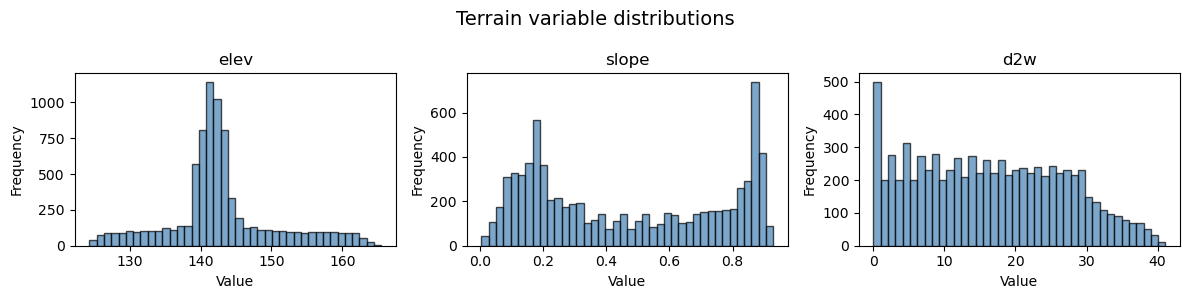

In [12]:
# --- Plot histograms of terrain variables (from vars_dict) ---
fig, axes = plt.subplots(1, len(vars_dict), figsize=(12, 3))

for ax, (v, arr) in zip(axes, vars_dict.items()):
    vals = arr.ravel()
    vals = vals[np.isfinite(vals)]  # drop NaN if any
    ax.hist(vals, bins=40, color="steelblue", edgecolor="k", alpha=0.7)
    ax.set_title(v)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Value")

plt.suptitle("Terrain variable distributions", fontsize=14)
plt.tight_layout()
plt.show()


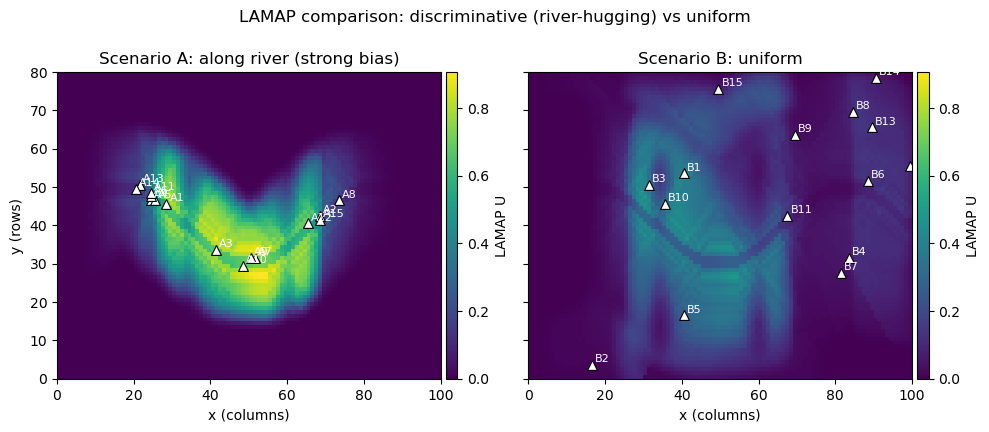

U_A stats: 0.0 0.9065729716212126 0.12288233574547451
U_B stats: 0.0 0.48149614611377944 0.11707670387990149


In [13]:
# ===== Global / shared parameters =====
N_SITES = 15                    # same # sites for both scenarios
eps     = {'elev': 2.0, 'slope': 0.10, 'd2w': 2.0}
K       = 10
rate    = 1.0
H, Wcols = next(iter(vars_dict.values())).shape
scale   = max(H, Wcols)
catchment_radius = 15
rng = np.random.default_rng()  # set to np.random.default_rng(123) for reproducibility

# ===== Scenario A: force sites along the river (strong discrimination) =====
d2w_arr   = vars_dict['d2w']
slope_arr = vars_dict['slope']
elev_arr  = vars_dict['elev']

# tight constraints
dmax_pix   = 5.0
slope_lo, slope_hi = 0.15, 0.50
use_elev_band = True
elev_mu  = np.percentile(elev_arr, 55)
elev_hw  = 6.0

near_river = d2w_arr <= dmax_pix
ok_slope   = (slope_arr >= slope_lo) & (slope_arr <= slope_hi)
ok_elev    = (np.abs(elev_arr - elev_mu) <= elev_hw) if use_elev_band else np.ones_like(elev_arr, bool)
eligible   = near_river & ok_slope & ok_elev

# relax if too few candidates
relax_steps = 0
while eligible.sum() < N_SITES and relax_steps < 10:
    dmax_pix *= 1.25
    near_river = d2w_arr <= dmax_pix
    eligible   = near_river & ok_slope & ok_elev
    relax_steps += 1

# weights to hug river; sample N_SITES distinct cells
epsw = 1e-3
wA = np.where(eligible, 1.0/(d2w_arr + epsw), 0.0).ravel()
pA = wA / wA.sum()
flat_idx_A = rng.choice(H*Wcols, size=N_SITES, replace=False, p=pA)

ygrid, xgrid = np.meshgrid(np.arange(H)+0.5, np.arange(Wcols)+0.5, indexing='ij')
sitesA = [Site(f"A{i+1}", float(xgrid.ravel()[idx]), float(ygrid.ravel()[idx])) for i, idx in enumerate(flat_idx_A)]

# ===== Scenario B: uniform random sites over the raster =====
flat_idx_B = rng.choice(H*Wcols, size=N_SITES, replace=False)
sitesB = [Site(f"B{i+1}", float(xgrid.ravel()[idx]), float(ygrid.ravel()[idx])) for i, idx in enumerate(flat_idx_B)]

# ===== Run LAMAP for both scenarios =====
U_A, dbgA = lamap_from_sites(sitesA, vars_dict, eps, K, rate, scale, catchment_radius)
U_B, dbgB = lamap_from_sites(sitesB, vars_dict, eps, K, rate, scale, catchment_radius)

# ===== Plot side-by-side (colorbars in side panes) =====
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

vmin = min(U_A.min(), U_B.min())
vmax = max(U_A.max(), U_B.max())

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
panels = [
    (axes[0], U_A, sitesA, "Scenario A: along river (strong bias)"),
    (axes[1], U_B, sitesB, "Scenario B: uniform"),
]

for ax, Umap, sites, title in panels:
    im = ax.imshow(Umap, origin="lower", extent=(0, Wcols, 0, H), vmin=vmin, vmax=vmax)
    sx = [s.x for s in sites]; sy = [s.y for s in sites]
    ax.scatter(sx, sy, s=50, marker="^", edgecolors="k", linewidths=0.8, c="white")
    for s in sites:
        ax.text(s.x+0.8, s.y+0.8, s.id, fontsize=8, color="white")
    ax.set_xlim(0, Wcols); ax.set_ylim(0, H)
    ax.set_title(title)

    # side colorbar (no overlap)
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="3%", pad=0.05)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("LAMAP U")

for ax in axes:
    ax.set_xlabel("x (columns)")
axes[0].set_ylabel("y (rows)")
fig.suptitle("LAMAP comparison: discriminative (river-hugging) vs uniform", y=1.03, fontsize=12)
plt.tight_layout()
plt.show()

print("U_A stats:", float(U_A.min()), float(U_A.max()), float(U_A.mean()))
print("U_B stats:", float(U_B.min()), float(U_B.max()), float(U_B.mean()))


In [14]:
import numpy as np
from typing import List, Tuple

def sample_sites_from_mask(mask: np.ndarray, n: int, rng=None) -> List[Site]:
    """
    Pick n distinct cells uniformly from a boolean mask (True = eligible).
    Returns a list of Site objects with cell centers as coordinates.
    """
    rng = np.random.default_rng() if rng is None else rng
    H, Wcols = mask.shape
    idx = np.flatnonzero(mask.ravel())
    if idx.size < n:
        raise ValueError(f"Mask has only {idx.size} eligible cells, need {n}.")
    picks = rng.choice(idx, size=n, replace=False)
    yy, xx = np.divmod(picks, Wcols)
    # +0.5 to match your existing grid convention
    return [Site(f"N{i+1}", float(xx[i] + 0.5), float(yy[i] + 0.5)) for i in range(n)]

def bootstrap_null_lamap(
    n_sites: int,
    R: int,
    vars_dict: dict,
    eps: dict,
    K: int,
    rate: float,
    scale: float,
    catchment_radius: float,
    mask: np.ndarray = None,
    seed=None,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Monte Carlo null: draw site sets under mask (CSR if mask=None), compute LAMAP R times.
    Returns (mean_U, sd_U), each H×W.
    """
    rng = np.random.default_rng(seed)
    H, Wcols = next(iter(vars_dict.values())).shape
    if mask is None:
        mask = np.ones((H, Wcols), dtype=bool)

    acc_mean = np.zeros((H, Wcols), dtype=np.float64)
    acc_m2   = np.zeros((H, Wcols), dtype=np.float64)  # for Welford online variance

    for r in range(1, R + 1):
        sites_r = sample_sites_from_mask(mask, n_sites, rng)
        U_r, _ = lamap_from_sites(sites_r, vars_dict, eps, K, rate, scale, catchment_radius)
        # online mean/variance (per cell)
        delta = U_r - acc_mean
        acc_mean += delta / r
        acc_m2   += delta * (U_r - acc_mean)
        if R <= 10 or (r % max(1, R // 10) == 0):
            print(f"null bootstrap {r}/{R}")

    mean_U = acc_mean
    sd_U = np.sqrt(acc_m2 / max(R - 1, 1))
    return mean_U, sd_U


null bootstrap 10/100
null bootstrap 20/100
null bootstrap 30/100
null bootstrap 40/100
null bootstrap 50/100
null bootstrap 60/100
null bootstrap 70/100
null bootstrap 80/100
null bootstrap 90/100
null bootstrap 100/100


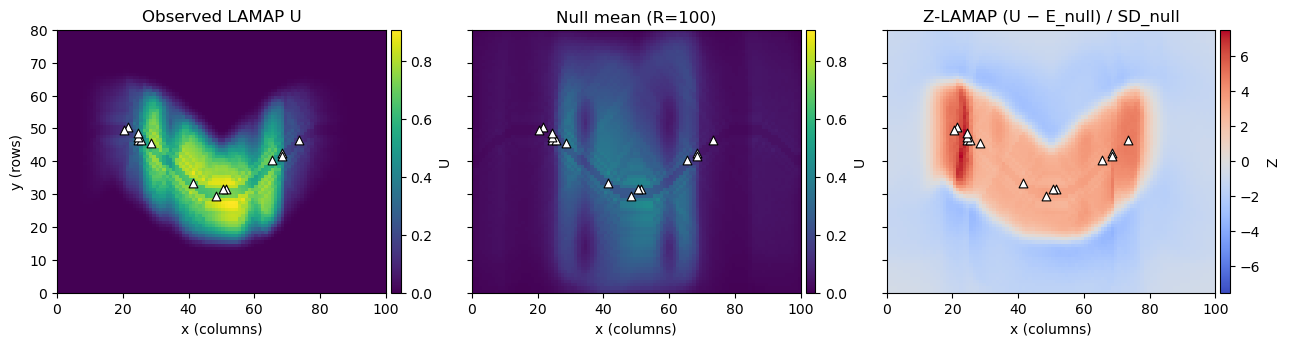

Observed U stats: 0.0 0.9065729716212126 0.12288233574547451
Null mean  stats: 0.0009663661398871229 0.4441628749114847 0.1099273861860983
Z stats: -3.477569688232802 7.517307431152036 -0.209934007937113


In [15]:
# Choose which scenario you want to baseline-correct
sites_obs = sitesA          # or sitesB
U_obs, _  = lamap_from_sites(sites_obs, vars_dict, eps, K, rate, scale, catchment_radius)

# ----- Choose the null you want -----
# CSR null (uniform over entire raster):
null_mask = np.ones_like(next(iter(vars_dict.values())), dtype=bool)

# ----- Bootstrap null -----
R = 100            # increase for smoother mean/SD
mean_null, sd_null = bootstrap_null_lamap(
    n_sites=len(sites_obs), R=R,
    vars_dict=vars_dict, eps=eps, K=K, rate=rate, scale=scale,
    catchment_radius=catchment_radius,
    mask=null_mask, seed=None   # seed=None => different each run
)

# ----- Standardize -----
eps_sd = 1e-9
Z = (U_obs - mean_null) / (sd_null + eps_sd)
Rmap = U_obs - mean_null

# --- Plots ---
H, Wcols = U_obs.shape
vminU = min(U_obs.min(), mean_null.min())
vmaxU = max(U_obs.max(), mean_null.max())
Zlim  = np.nanmax(np.abs(Z)) or 1.0  # guard against all-zeros
vminZ, vmaxZ = -Zlim, Zlim

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharex=True, sharey=True)

# Panel 1: Observed U
im0 = axes[0].imshow(U_obs, origin="lower", extent=(0, Wcols, 0, H),
                     vmin=vminU, vmax=vmaxU)
axes[0].set_title("Observed LAMAP U")

# Panel 2: Null mean
im1 = axes[1].imshow(mean_null, origin="lower", extent=(0, Wcols, 0, H),
                     vmin=vminU, vmax=vmaxU)
axes[1].set_title(f"Null mean (R={R})")

# Panel 3: Z-LAMAP
im2 = axes[2].imshow(Z, origin="lower", extent=(0, Wcols, 0, H),
                     cmap="coolwarm", vmin=vminZ, vmax=vmaxZ)
axes[2].set_title("Z-LAMAP (U − E_null) / SD_null")

# Overlay sites on all panels
sx = [s.x for s in sites_obs]; sy = [s.y for s in sites_obs]
for ax in axes:
    ax.scatter(sx, sy, s=40, marker="^", edgecolors="k", c="white", linewidths=0.8)
    ax.set_xlim(0, Wcols); ax.set_ylim(0, H)

# Side colorbars (no overlap)
for ax, im, lab in [(axes[0], im0, "U"), (axes[1], im1, "U"), (axes[2], im2, "Z")]:
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="3%", pad=0.05)
    cb  = fig.colorbar(im, cax=cax)
    cb.set_label(lab)

# Axis labels
for ax in axes:
    ax.set_xlabel("x (columns)")
axes[0].set_ylabel("y (rows)")

plt.tight_layout()
plt.show()

print("Observed U stats:", float(U_obs.min()), float(U_obs.max()), float(U_obs.mean()))
print("Null mean  stats:", float(mean_null.min()), float(mean_null.max()), float(mean_null.mean()))
print("Z stats:", float(Z.min()), float(Z.max()), float(np.nanmean(Z)))

null bootstrap 10/100
null bootstrap 20/100
null bootstrap 30/100
null bootstrap 40/100
null bootstrap 50/100
null bootstrap 60/100
null bootstrap 70/100
null bootstrap 80/100
null bootstrap 90/100
null bootstrap 100/100


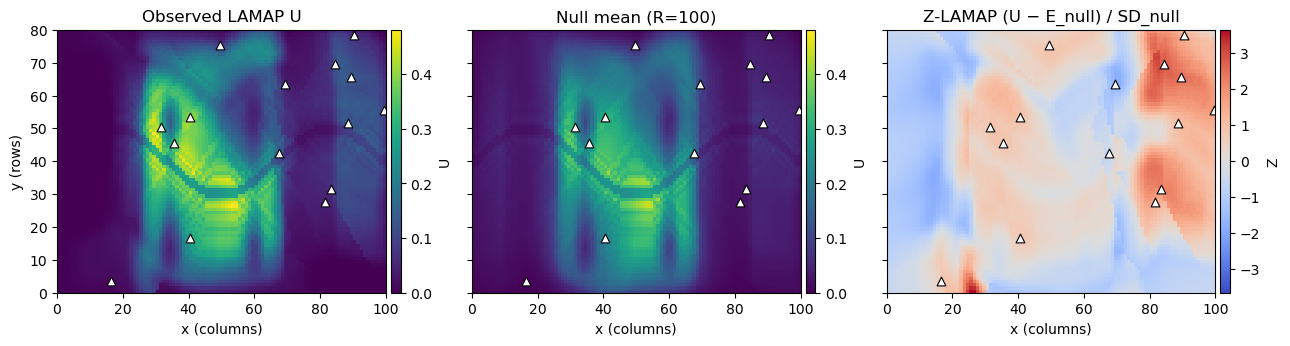

Observed U stats: 0.0 0.48149614611377944 0.11707670387990149
Null mean  stats: 0.0011632342265142494 0.43830360841310595 0.10826090811425451
Z stats: -1.9201857067728383 3.655657747499037 0.06759224627944468


In [16]:
# Choose which scenario you want to baseline-correct
sites_obs = sitesB
U_obs, _  = lamap_from_sites(sites_obs, vars_dict, eps, K, rate, scale, catchment_radius)

# ----- Choose the null you want -----
# CSR null (uniform over entire raster):
null_mask = np.ones_like(next(iter(vars_dict.values())), dtype=bool)

# ----- Bootstrap null -----
R = 100            # increase for smoother mean/SD
mean_null, sd_null = bootstrap_null_lamap(
    n_sites=len(sites_obs), R=R,
    vars_dict=vars_dict, eps=eps, K=K, rate=rate, scale=scale,
    catchment_radius=catchment_radius,
    mask=null_mask, seed=None   # seed=None => different each run
)

# ----- Standardize -----
eps_sd = 1e-9
Z = (U_obs - mean_null) / (sd_null + eps_sd)
Rmap = U_obs - mean_null

# --- Plots ---
H, Wcols = U_obs.shape
vminU = min(U_obs.min(), mean_null.min())
vmaxU = max(U_obs.max(), mean_null.max())
Zlim  = np.nanmax(np.abs(Z)) or 1.0  # guard against all-zeros
vminZ, vmaxZ = -Zlim, Zlim

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharex=True, sharey=True)

# Panel 1: Observed U
im0 = axes[0].imshow(U_obs, origin="lower", extent=(0, Wcols, 0, H),
                     vmin=vminU, vmax=vmaxU)
axes[0].set_title("Observed LAMAP U")

# Panel 2: Null mean
im1 = axes[1].imshow(mean_null, origin="lower", extent=(0, Wcols, 0, H),
                     vmin=vminU, vmax=vmaxU)
axes[1].set_title(f"Null mean (R={R})")

# Panel 3: Z-LAMAP
im2 = axes[2].imshow(Z, origin="lower", extent=(0, Wcols, 0, H),
                     cmap="coolwarm", vmin=vminZ, vmax=vmaxZ)
axes[2].set_title("Z-LAMAP (U − E_null) / SD_null")

# Overlay sites on all panels
sx = [s.x for s in sites_obs]; sy = [s.y for s in sites_obs]
for ax in axes:
    ax.scatter(sx, sy, s=40, marker="^", edgecolors="k", c="white", linewidths=0.8)
    ax.set_xlim(0, Wcols); ax.set_ylim(0, H)

# Side colorbars (no overlap)
for ax, im, lab in [(axes[0], im0, "U"), (axes[1], im1, "U"), (axes[2], im2, "Z")]:
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="3%", pad=0.05)
    cb  = fig.colorbar(im, cax=cax)
    cb.set_label(lab)

# Axis labels
for ax in axes:
    ax.set_xlabel("x (columns)")
axes[0].set_ylabel("y (rows)")

plt.tight_layout()
plt.show()

print("Observed U stats:", float(U_obs.min()), float(U_obs.max()), float(U_obs.mean()))
print("Null mean  stats:", float(mean_null.min()), float(mean_null.max()), float(mean_null.mean()))
print("Z stats:", float(Z.min()), float(Z.max()), float(np.nanmean(Z)))


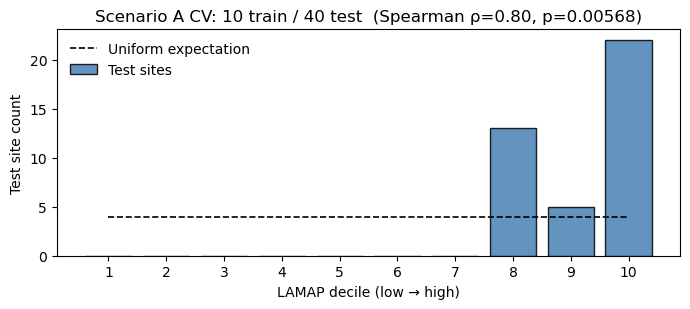

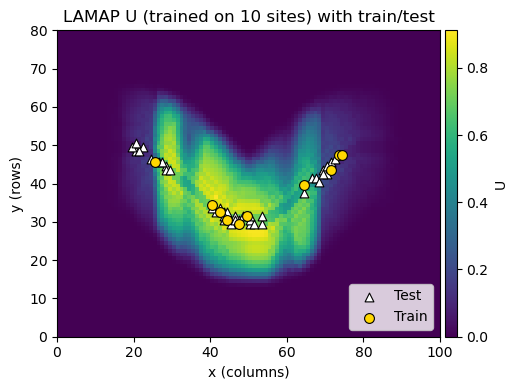

Counts per decile: [0, 0, 0, 0, 0, 0, 0, 13, 5, 22]
Spearman rho = 0.7979, p = 0.00568


In [17]:
# === Scenario A cross-validation: 10 train / 40 test, decile analysis ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from mpl_toolkits.axes_grid1 import make_axes_locatable

rng = np.random.default_rng()  # set a seed here for reproducibility if you like

# ----- Shared LAMAP params -----
N_TOTAL = 50
N_TRAIN = 10
N_TEST  = N_TOTAL - N_TRAIN
eps     = {'elev': 2.0, 'slope': 0.10, 'd2w': 2.0}
K       = 10
H, Wcols = next(iter(vars_dict.values())).shape
rate    = 1.0
scale   = max(H, Wcols)
catchment_radius = 15

# ----- Scenario A sampler: river-hugging + slope band (+ optional elevation band) -----
d2w_arr   = vars_dict['d2w']
slope_arr = vars_dict['slope']
elev_arr  = vars_dict['elev']

dmax_pix   = 5.0
slope_lo, slope_hi = 0.15, 0.50
use_elev_band = True
elev_mu = np.percentile(elev_arr, 55)
elev_hw = 6.0

near_river = d2w_arr <= dmax_pix
ok_slope   = (slope_arr >= slope_lo) & (slope_arr <= slope_hi)
ok_elev    = (np.abs(elev_arr - elev_mu) <= elev_hw) if use_elev_band else np.ones_like(elev_arr, bool)
eligible   = near_river & ok_slope & ok_elev

# relax eligibility if too tight
relax = 0
while eligible.sum() < N_TOTAL and relax < 10:
    dmax_pix *= 1.25
    near_river = d2w_arr <= dmax_pix
    eligible   = near_river & ok_slope & ok_elev
    relax += 1

# weight to hug river strongly, then sample N_TOTAL distinct cells
epsw = 1e-3
wA = np.where(eligible, 1.0/(d2w_arr + epsw), 0.0).ravel()
pA = wA / wA.sum()

ygrid, xgrid = np.meshgrid(np.arange(H)+0.5, np.arange(Wcols)+0.5, indexing='ij')
flat_idx = rng.choice(H*Wcols, size=N_TOTAL, replace=False, p=pA)
sites_all = [Site(f"S{i+1}", float(xgrid.ravel()[idx]), float(ygrid.ravel()[idx])) for i, idx in enumerate(flat_idx)]

# ----- Split: 10 train / 40 test -----
perm = rng.permutation(N_TOTAL)
train_idx = perm[:N_TRAIN]
test_idx  = perm[N_TRAIN:]
sites_train = [sites_all[i] for i in train_idx]
sites_test  = [sites_all[i] for i in test_idx]

# ----- Train LAMAP on the 10 train sites -----
U_train, _ = lamap_from_sites(sites_train, vars_dict, eps, K, rate, scale, catchment_radius)

# ----- Quantile binning (deciles) over entire U surface -----
nbins = 10
U_flat = U_train.ravel()
# guard against constant arrays
if np.allclose(U_flat.min(), U_flat.max()):
    # jitter tiny noise to avoid identical quantiles
    U_flat = U_flat + 1e-12 * rng.standard_normal(U_flat.size)
q_edges = np.quantile(U_flat, np.linspace(0, 1, nbins+1))
# ensure strictly increasing (tolerate ties)
q_edges = np.maximum.accumulate(q_edges)

# ----- Assign each test site to a bin based on its U value -----
def sample_U_at_site(U, s: Site):
    # nearest-cell sampling (grid centers at .5)
    ix = int(np.clip(np.round(s.x - 0.5), 0, Wcols-1))
    iy = int(np.clip(np.round(s.y - 0.5), 0, H-1))
    return float(U[iy, ix])

U_test_vals = np.array([sample_U_at_site(U_train, s) for s in sites_test])
# digitize: bins are [edge[i], edge[i+1]) except the last (closed on right)
bin_ids = np.digitize(U_test_vals, q_edges[1:-1], right=False)  # 0..nbins-1

counts = np.bincount(bin_ids, minlength=nbins)
expected = np.full(nbins, N_TEST/nbins)  # uniform null expectation

# correlation between bin index (1..nbins) and counts
rho, pval = spearmanr(np.arange(1, nbins+1), counts)

# ----- Plot bars -----
fig, ax = plt.subplots(figsize=(7, 3.2))
x = np.arange(1, nbins+1)
bars = ax.bar(x, counts, width=0.8, color="steelblue", edgecolor="k", alpha=0.85, label="Test sites")
ax.plot(x, expected, "k--", linewidth=1.2, label="Uniform expectation")
ax.set_xticks(x)
ax.set_xlabel("LAMAP decile (low → high)")
ax.set_ylabel("Test site count")
ax.set_title(f"Scenario A CV: 10 train / 40 test  (Spearman ρ={rho:.2f}, p={pval:.3g})")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# ----- (Optional) show train/test over the U map for context -----
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5.8, 4))
im = ax.imshow(U_train, origin="lower", extent=(0, Wcols, 0, H))
ax.set_title("LAMAP U (trained on 10 sites) with train/test")
sxT = [s.x for s in sites_train]; syT = [s.y for s in sites_train]
sxE = [s.x for s in sites_test];  syE = [s.y for s in sites_test]
ax.scatter(sxE, syE, s=40, marker="^", edgecolors="k", c="white", linewidths=0.8, label="Test")
ax.scatter(sxT, syT, s=50, marker="o", edgecolors="k", c="gold", linewidths=0.8, label="Train")
ax.set_xlim(0, Wcols); ax.set_ylim(0, H); ax.set_xlabel("x (columns)"); ax.set_ylabel("y (rows)")
div = make_axes_locatable(ax); cax = div.append_axes("right", size="3%", pad=0.05)
cb = fig.colorbar(im, cax=cax); cb.set_label("U")
ax.legend(loc="lower right", frameon=True, facecolor="white", framealpha=0.8)
plt.tight_layout(); plt.show()

print("Counts per decile:", counts.tolist())
print(f"Spearman rho = {rho:.4f}, p = {pval:.3g}")
